In [1]:
# Setup for Keras

# Common imports
import numpy as np
import os
import pandas as pd
import sklearn

import tensorflow as tf
import keras #requirement: keras 3
os.environ["KERAS_BACKEND"] = "tensorflow"
#os.environ["KERAS_BACKEND"] = "pytorch"

# to make this notebook's output stable across runs
np.random.seed(42)
keras.utils.set_random_seed(42)

print(tf.__version__) #requirement: >= 15

# Where to save the models
PROJECT_ROOT_DIR = "."
MODEL_PATH = os.path.join(PROJECT_ROOT_DIR, "models")
os.makedirs(MODEL_PATH, exist_ok=True)


# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

/opt/homebrew/anaconda3/envs/ml/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/opt/homebrew/anaconda3/envs/ml/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


2.16.1


First check GPU availability: 

In [2]:
tf.config.experimental.list_physical_devices('GPU')

[]

# Practical 1: MLP with Keras (MNIST)

In this first practical we train a simple MLP on the Fashion MNIST data and check the training progress on TensorBoard.
We experience the exploding gradient problem with deep MLPs first hand and try out learning schedules.  

**Aim:** Get a basic understanding of MLPs and dimensions, get to know the basic principles of Keras and monitoring the training process with TensorBoard. 

First, we load the data. 

In [4]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

Split up the full train set and the train labels into a validation set `X_valid` (5000 instances) with validation labels `y_valid`  and a train set `X_train` with labels `y_train`. 

In [ ]:
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

Find out any way you want how many different classes there are in the Fashion MNIST data. 

In [5]:
print(set(y_train_full))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


Data preprocessing: Scale all inputs (test, train and validation set) to mean 0 and standard deviation 1 first. 

In [6]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

Now set the random seed for keras and np to 42 to make outputs stable across runs. 

Also, in case you run the code several times, precede these random seed settings by a clear_session() to make sure Keras doesn't screw anything up. 

Then, define a model for the **Fashion MNIST classification problem** using Keras Sequential API with all layers within `Sequential()`, which does the following: 
- first, turn the 2D-input into a vector (Flatten)
- First hidden layer: 300 units, to set the initialization to HeNormal, use the keyword `kernel_initializer`, see [documentation](https://keras.io/api/layers/initializers/)
- activation function for the first layer: LeakyReLU
- Second hidden layer: 100 units, again set the initialization to HeNormal
- activation function for the second layer: LeakyReLU
- a classification layer (what does this have to look like?). Determine how many output neurons you need yourself! 

**Question:** Explain why He initialization (or other initialization heuristics in other cases) is used and why it stabilizes training at least at the beginning! 

**Answer:** **Answer:** #TODO

The aim of initialization is to prevent exploding or vanishing gradients at the beginning of training. Sampling the weights to be random small values from a standard normal distribution keeps the values of activations small at the beginning of training and breaks the symmetry.  The factors (He LeCun etc) are a heuristic to make the variance of all layer activations stable across layers for different activation functions at least at the beginning of training (afterwards, the weights change and variances can change). Here we use He since the activations are ReLUs.

In [7]:
keras.backend.clear_session()
keras.utils.set_random_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

/opt/homebrew/anaconda3/envs/ml/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Question:** How many parameters do you have in this not very deep NN? Derive the number by computation.

**Answer:** 

dense_1: $28\cdot28\cdot300+300=235500$

dense_2: $300\cdot 100+100=30100$

dense_3=output: $100\cdot 10+10=1010$

total: 266610

Check your result by getting the model's summary. 

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

**Question:** What is the advantage of LeakyReLU
- over the sigmoid function?
- over ReLU?
If you are not sure how to set the slope in the negative part, what could you do?

**Answer:** #TODO
- the sigmoid is saturating, therefore for large absolute values, the gradients vanish, which can lead to the vanishing gradient problem. Leaky ReLU is not saturating.
- The gradient of SeLU is easier to compute.
- advantage over ReLU: if the pre-activations of a neuron get negative during training, the output of a ReLU neuron will be constant = 0, so the gradient will be zero, and no learning is possible. The neuron will be "dead". Leaky ReLU is non-saturating for negative pre-activations.

Compile the model using SGD; additionally ask the model to output accuracy as a metric. 

**Question:** Which other method (that is however not an option in compile, but would have to be constructed afterwards) could you use to view how good your model is and even find out which classes it predicts best/worst?

**Answer:** #TODO
confusion matrix


In [9]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

### Setting up TensorBoard for Monitoring the Training Process

We want to log our training process and visualize it with TensorBoard to see if the models overfit or how well training works. 


Start TensorBoard with the below code and go to localhost:6006

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

Create log files for Tensorboard with the TensorBoard callback: 
First, define the path of the log files:

In [10]:
root_logdir = os.path.join(PROJECT_ROOT_DIR, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./my_logs/run_2024_04_07-20_47_21'

Then, define the Tensorboard callback.
Also, define a Checkpoint so the model can be rolled back to the best one.

Attention! Keras' ModelCheckpoint sometimes leads to erratic errors if the file already exists. Therefore (just in case you run this code several times) add some code that deletes the model if it exists before you define the checkpoints. 

Also: If Keras still gives you an error on the ModelCheckpoint callback, restart the kernel and try again. 

In [11]:
kerasmodelpath = os.path.join(MODEL_PATH, "tutorial1_keras_model.keras")
try:
    os.remove(kerasmodelpath)
except OSError:
    pass


tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
checkpoint_cb = keras.callbacks.ModelCheckpoint(kerasmodelpath, save_best_only=True)

### Training and evaluating the model

Fit the model by training for 5 epochs, using the tensorboard callback and the checkpoint callback. 
Then rollback to the best model by loading the best model.

In [12]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid), 
                    callbacks=[checkpoint_cb, tensorboard_cb])

# rollback to best model
model = keras.models.load_model(kerasmodelpath) # rollback to best model

Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6037 - loss: 1.2130 - val_accuracy: 0.7882 - val_loss: 0.6032
Epoch 2/5
 613/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7910 - loss: 0.5945

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7968 - loss: 0.5810 - val_accuracy: 0.8180 - val_loss: 0.5224
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8194 - loss: 0.5104 - val_accuracy: 0.8312 - val_loss: 0.4851
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8318 - loss: 0.4735 - val_accuracy: 0.8430 - val_loss: 0.4624
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8416 - loss: 0.4492 - val_accuracy: 0.8492 - val_loss: 0.4467


Evaluate the model on the test data:

In [13]:
model.evaluate(X_test_scaled, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - accuracy: 0.8290 - loss: 0.4758


[0.4788869619369507, 0.8278999924659729]

IMPORTANT NOTE: These trained models will not be used later on (except for comoparison of accuracy), which is why we don't save them. However, if you want, you can save all the trained models. 

Now we modify our model.
Reset the random seeds. 

In [14]:
keras.backend.clear_session()
keras.utils.set_random_seed(42)
np.random.seed(42)

### Deep Model - Vanishing/Exploding Gradients

Let's make the above model a lot deeper (>60 Layers!) and compare the results. However, for deep models, computing the gradient can be instable: for 50 layers, computing the gradient boils down to using the chain rule at least 60 times! 

In the following cell, use the Sequential API of Keras using model.add to build the same model as above, with the following modification: 
- repeat the 100-unit-dense layer before the output layer 60 times

In [15]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, kernel_initializer="he_normal"))
model.add(keras.layers.LeakyReLU())
for layer in range(60):
    model.add(keras.layers.Dense(100, activation="selu", kernel_initializer="he_normal"))
    model.add(keras.layers.LeakyReLU())
model.add(keras.layers.Dense(10, activation="softmax"))

**Question:**
What is the number of trainable parameters now? Again, first use theory to arrive at a number before you check it with code.

**Answer:** #TODO
dense_1: $28\cdot28\cdot300+300=235500$

dense_2: $300\cdot 100+100=30100$

dense_3 to dense_101 (59 times): $100 \cdot 100 +100=10.100\Rightarrow $ 494.900 in total

dense_3=output: $100\cdot 10+10=1010$
total: 862510 parameters


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 100)            │             

 Total params: 862,510 (3.29 MB)

 Trainable params: 862,510 (3.29 MB)

 Non-trainable params: 0 (0.00 B)

Compile and train the model with SGD and additional metric accuracy.

In [17]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

Now let's train it for 5 epochs, again with (only) the TensorBoard Callback, where we create a new log_dir path. 

In [18]:
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid), 
                    callbacks=tensorboard_cb)


Epoch 1/5
 551/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.2498 - loss: 3.0841

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.4291 - loss: 1.9235 - val_accuracy: 0.7450 - val_loss: 0.7024
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7486 - loss: 0.6898 - val_accuracy: 0.7916 - val_loss: 0.5867
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7957 - loss: 0.5740 - val_accuracy: 0.8170 - val_loss: 0.5232
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8161 - loss: 0.5121 - val_accuracy: 0.8278 - val_loss: 0.5076
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8329 - loss: 0.4735 - val_accuracy: 0.8332 - val_loss: 0.4802


Evaluate the model. What might be the problem?

**Answer**:
- If the derivatives for each layer are very small, the total gradient will almost vanish (vanishing gradient problem)!
- If the derivatives for each layer are large, the total gradient will explode (exploding gradient problem)!
One way of dealing with this is to make sure that the mean and variance of output and input of each layer are similar, so in each layer, nothing "drastic" happens that might lead to small or big gradients. 

In [19]:
model.evaluate(X_test_scaled, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8250 - loss: 0.5051


[0.5145449042320251, 0.8208000063896179]

### A theoretical exercise on MLPs

**Question:**

Suppose we have a shallow regression network with 1 input units, 2 hidden units with activation function=$\sin$, 1 sigmoid output unit, with biases. 
- Draw the architecture. How many are there? 
- Write the pre-activation, activation and output for one input $x$ in terms of the weights and biases.


**Solution:**

|architecture|formulae|
|:---|:---|
|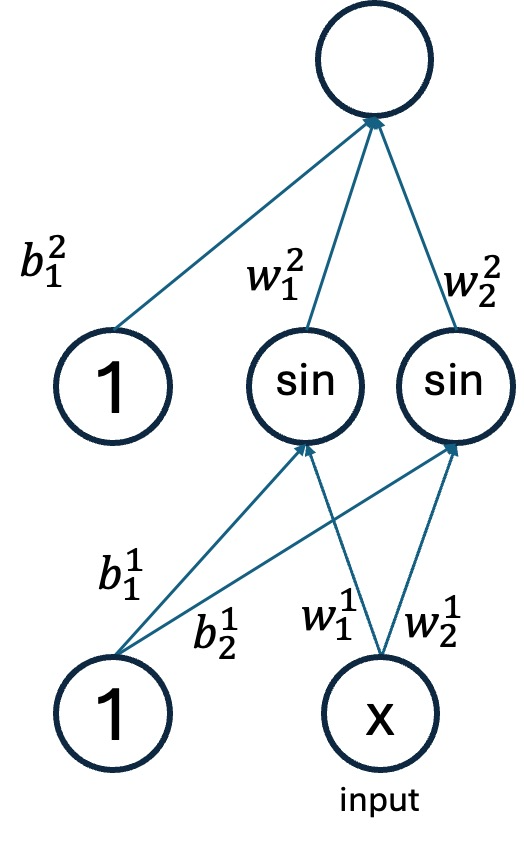|<br>**output:**<br> $\sigma(w_1^2\cdot (\sin(w_1^1\cdot x+b_1^1)+w_2^2\cdot \sin(w_2^1\cdot x+b_2^1)+b_1^2 )$  <br><br><br> <br>  activation: <br><br> $(\sin(w_1^1\cdot x+b_1^1), \sin(w_2^1\cdot x+b_2^1)) $   <br><br><br>  pre-activation:<br><br> $ (w_1^1\cdot x+b_1^1, w_2^1\cdot x+b_2^1)$ <br><br><br> <br><br> <br><br> |

**Question 2:**

Suppose you have a Feedforward Network for 5-class Classification and: 
- 10 input features, 
- one hidden layer with 100 units with ReLU activation (and biases)
- a second hidden layer with 200 units with Parametric ReLU activation (and biases)
- a third hidden layer with 50 units and SELU activation (and biases)
- an output layer 



1. What does the output layer have to look like for 5-class classification?


2. Fill out the x-es in the following table: 



|Layer|number of weights|number of biases|additional parameters|
|:---|:---|:---|:---|
|first layer|x|x|x|
|second layer|x|x|x|
|third layer|x|x|x|
|output layer|x|x|x|

1. Let $W_i, b_i$ be weight matrix and bias vector for the ith layer. Write the activations of all layers as function in the output vector of the layer below (denote the activations=outputs of layer i by $z_i$) 
   
|Layer|Output|
|:---|:---|
|first layer|x|
|second layer|x|
|third layer|x|
|output layer|x|
   
1. Write the output in terms of matrices and vectors for 
- only one instance
- a mini-batch of size 128 called X
and give the dimensions of all matrices and vectors you use! Here you can write $B_i$ for the matrix with the bias vector $b_i$ in each row.


**Solution:**

1. The output layer has 5 units followed by a softmax to get a probability vector with 5 entries, one for each class.
   
2. Number of parameters: 

|Layer|number of weights|number of biases|additional parameters|
|:---|:---|:---|:---|
|first layer|10x100=1.000|100=number of units in the "upper" layer|0|
|second layer|100x200=20.000|200| 1x200|
|third layer|200x50 = 10.000|50| 2x50=100|
|output layer|50x5=250|5|0|

3.  
|Layer|Output|
|:---|:---|
|first layer|$z_1=ReLU(W_1x+b_1)$|
|second layer|$z_2=PReLU(W_2z_1+b_2)$|
|third layer|$z_3=SeLU(W_3z_2+b_3)$|
|output layer|output $=Softmax(W_4z_3+b_4)$|

4. $output (x) = Softmax\left(W_4\cdot SeLU\left(W_3\cdot PReLU\left(W_2\cdot ReLU(W_1x+b_1)+b_2\right)+b_3\right)+b_4\right)$
   
   $output (X) = Softmax\left(SeLU\left(PReLU\left(ReLU(XW_1^T+B_1)W_2^T+B_2\right)W_3^T+B_3\right)W_4^T+B_4\right)$

**Question 3:**

Suppose you have a Regression Feedforward Network to predict tomorrow's temperature, wind speed, an air pressure at midday. You have as input
- 20 input features, 
- one hidden layer with 30 units 
- a second hidden layer with 40 units 
- an output layer 
where you have sigmoid activation functions for all hidden layers.

1. What is the number of parameters of each layer?
   
   Solution: 
   three-dimensional regression, i.e. the output layer has three neurons
   parameters: first layer: $20\cdot 30+30=630$, second layer: $30\cdot 40+40 = 1240$, third layer: $40\cdot 3+3=123$

2. If you have very large values as inputs and the network does not learn, what could be the problem?
   
   Solution: The sigmoid is saturating for large absolute values. Therefore you might have a vanishing gradient problem. 

3. What are the dimensions of the weight matrices $W_1, W_2, W_3$ and biases $b_1,b_2,b_3$?
   
   Solution: $30\times 20, 40\times 30, 3\times 40$ and $30, 40, 3$.


4. Write down the formula for the output for a single input $x$: 

    Solution: $W_3\cdot \sigma\left(W_2\cdot \sigma\left(W_1\cdot x+b_1\right)+b_2\right)+b_3$

**Question 4:**

Suppose you have a MLP for binary classification without biases, and for some input $x$ we know the following about the last hidden layer: 
- all pre-activations in this hidden layer are negative, 
- the activation function of the hidden layer is a ReLU. 
What is the output probabilitiy of the positive class for input $x$?

Solution: 0.5
- Since it is a binarly classification network, there is only one output neuron with a sigmoid. 
- ReLU applied to negative values gives 0 activations in the last hidden layer. 
- Any linear function applied to 0 is 0, and since there is no bias, the pre-activation for the output neuron is 0. 
- Applying the sigmoid to 0 gives 0.5